# Lennard-Jones Potentials for modelling phase transitions in materials

Nested Sampling is the ideal tool for computing the partition function.

$$Z(\beta) = \int_\mathcal{X} e^{-\beta E(x)} \, \mathrm{d}x$$

where $\beta \in [0, \infty)$ is the inverse temperature parameter, $\mathcal{X}$ is the set of all configurations of the system, and $E : \mathcal{X} \to \mathbb{R}$ is the potential function, which in this case will be the Lennard-Jones potential,

$$E(x) = 4 \epsilon \sum_{i,j} \left( \left(\frac{\sigma}{r_{ij}}\right)^{12} - \left(\frac{\sigma}{r_{ij}}\right)^6 \right).$$

In this equation, the $-\epsilon$ represents the energy of the ground state, and $\sigma$ is the equilibrium distance when the potential energy is zero.

The system is invariant to changes in sigma and the total size of the region. Therefore, we choose $\sigma$ as a ratio with the size of the box. We'll chose to sample states within a unit box, therefore, we are choosing how big the box is in units of $\sigma$. Choosing $\sigma=0.01$ is equivalent to choosing, means the volume is roughly 100 particles per side.

In [1]:


from jax.config import config

config.update("jax_enable_x64", True)

import tensorflow_probability.substrates.jax as tfp
from jax import random, numpy as jnp
from jax import vmap

from jaxns import Model
from jaxns import Prior

tfpd = tfp.distributions


INFO[2023-12-11 13:43:29,477]: Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO[2023-12-11 13:43:29,478]: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO[2023-12-11 13:43:29,478]: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
WARNING[2023-12-11 13:43:29,479]: An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [2]:

def pairwise_distances_squared(points):
    n = points.shape[0]
    pair_indices = jnp.triu_indices(n, 1)  # Upper triangular indices, excluding diagonal

    # Create function that calculates the distance between two points
    def dist_fn(ij):
        i, j = ij
        return jnp.sum(jnp.square(points[i] - points[j]))

    # Apply this function to each pair of indices
    pairwise_distances = vmap(dist_fn)(pair_indices)

    return pairwise_distances


def test_pairwise_distances_squared():
    # Example usage
    points = jnp.array([[1, 2], [3, 4], [5, 6], [7, 8]])
    assert jnp.all(pairwise_distances_squared(points) == jnp.asarray([8, 32, 72, 8, 32, 8]))

In [3]:


from jaxns.internals.log_semiring import LogSpace

num_particles = 4
sigma = jnp.asarray(0.439)
box_length = jnp.asarray(4.)


def log_likelihood(x):
    """
    V12-6 potential for LJ.
    """

    r2 = LogSpace(jnp.log(pairwise_distances_squared(x / sigma)))
    r6 = r2 * r2 * r2
    r12 = r6 * r6
    negE = r12 ** (-1) - r6 ** (-1)

    return negE.sum().value


def prior_model():
    x = yield Prior(tfpd.Uniform(low=jnp.zeros((num_particles, 3)), high=box_length * jnp.ones((num_particles, 3))),
                    name='x')
    return x


model = Model(prior_model=prior_model,
              log_likelihood=log_likelihood)

model.sanity_check(random.PRNGKey(42), 1000)


INFO[2023-12-11 13:43:30,229]: Sanity check...
INFO[2023-12-11 13:43:30,726]: Sanity check passed


In [4]:
import jax
from jaxns import TerminationCondition
from jaxns.samplers import UniDimSliceSampler
from jaxns.nested_sampler import StandardStaticNestedSampler

# Create the nested sampler class. In this case without any tuning.
ns = StandardStaticNestedSampler(
    model=model,
    num_live_points=100,  #model.U_ndims * 200,
    max_samples=1e6,
    sampler=UniDimSliceSampler(model=model, num_slices=model.U_ndims * 1, num_phantom_save=0, midpoint_shrink=True,
                               perfect=True),
    init_efficiency_threshold=0.1

)

ns_compiled = jax.jit(lambda key: ns._run(key, term_cond=TerminationCondition())).lower(
    jax.random.PRNGKey(42)).compile()

termination_reason, state = ns_compiled(random.PRNGKey(42))

results = ns._to_results(
    termination_reason=termination_reason,
    state=state,
    trim=True
)


/home/albert/miniconda3/envs/jaxns_py/lib/python3.11/site-packages/jax/_src/ops/scatter.py:94: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float64 to dtype=int64 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "


In [5]:
from jaxns import summary

# We can use the summary utility to display results
summary(results)

--------
Termination Conditions:
Small remaining evidence
--------
likelihood evals: 10612251
samples: 19500
phantom samples: 0.0
likelihood evals / sample: 544.2
phantom fraction (%): 0.0%
--------
logZ=1.993860455038995e+190 +- 1.5e-08
H=inf
ESS=1.0
--------
x[#]: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
x[0]: 3.5 +- 0.0 | 3.5 / 3.5 / 3.5 | 3.5 | 3.5
x[1]: 3.7377796309678804 +- 4.4e-16 | 3.73777963096788 / 3.73777963096788 / 3.73777963096788 | 3.73777963096788 | 3.73777963096788
x[2]: 3.4596747783645925 +- 4.4e-16 | 3.459674778364592 / 3.459674778364592 / 3.459674778364592 | 3.459674778364592 | 3.459674778364592
x[3]: 2.68540726042173 +- 6.1e-16 | 2.6854072604217296 / 2.68540726042173 / 2.685407260421731 | 2.6854072604217296 | 2.6854072604217296
x[4]: 2.678382850631735 +- 2.8e-16 | 2.6783828506317344 / 2.678382850631735 / 2.6783828506317353 | 2.678382850631735 | 2.678382850631735
x[5]: 3.768847499725044 +- 9.4e-16 | 3.7688474997250427 / 3.7688474997250436 

WARNING[2023-12-11 13:46:54,562]: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


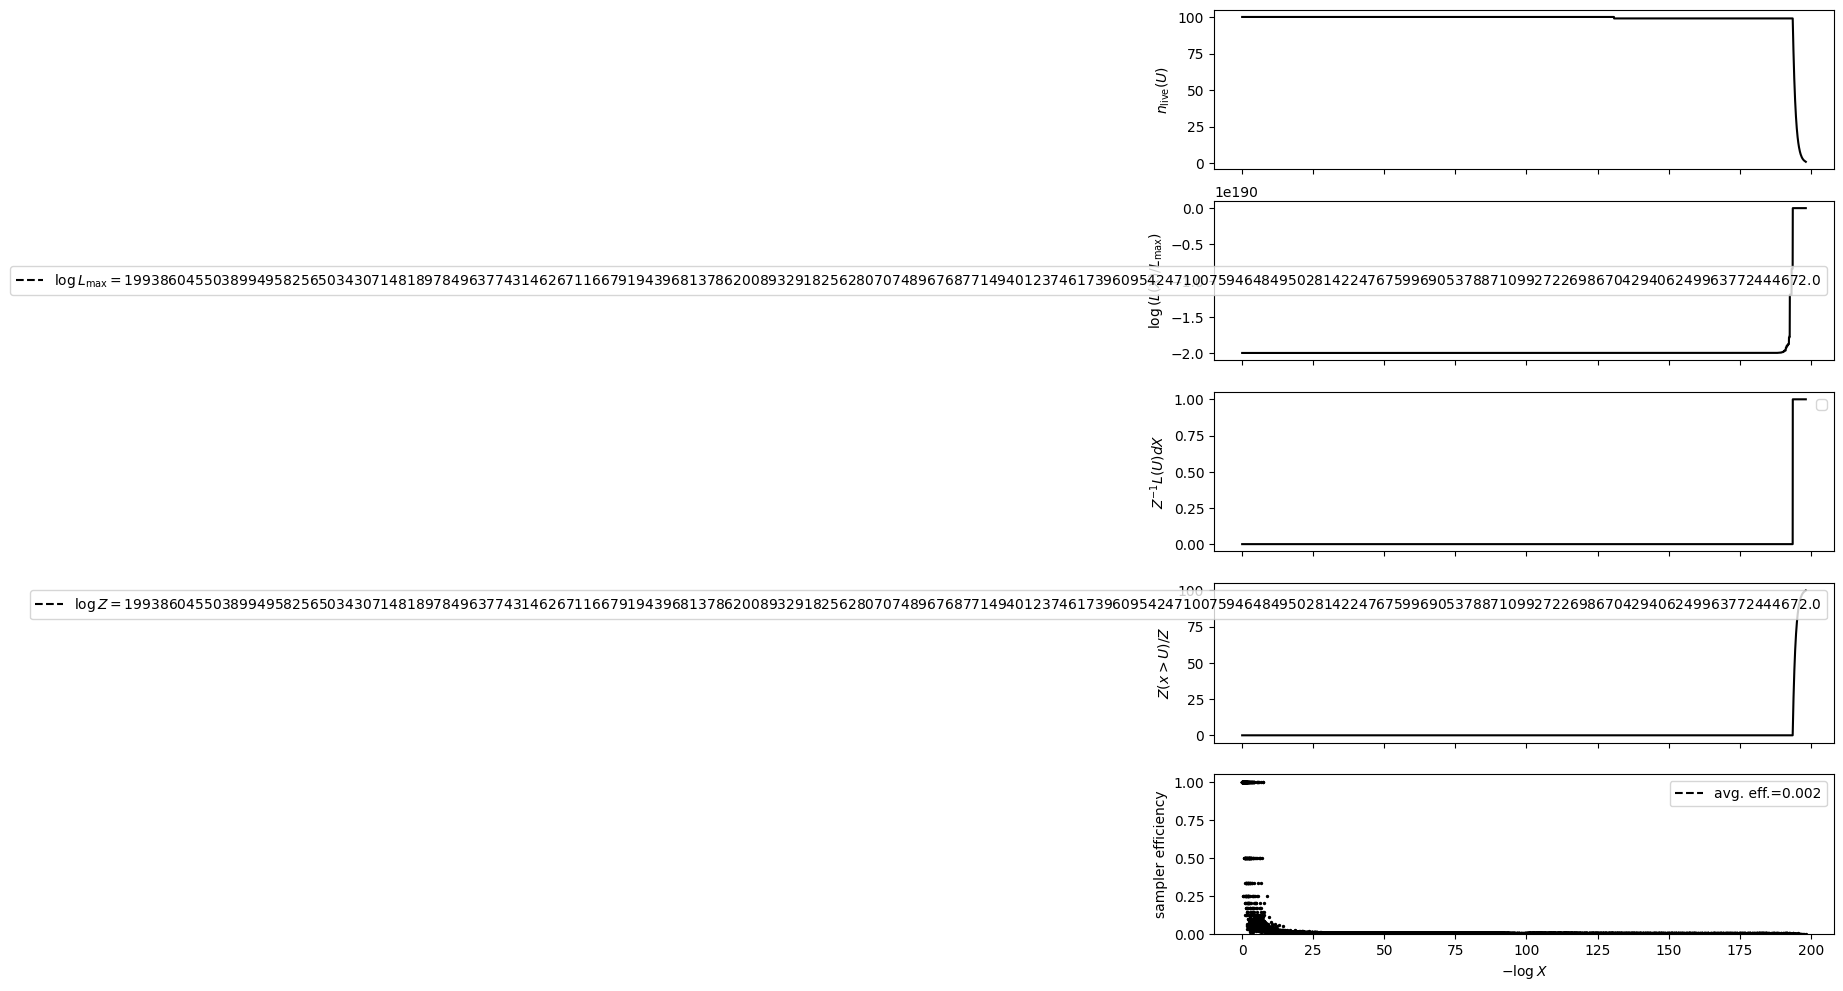

/home/albert/miniconda3/envs/jaxns_py/lib/python3.11/site-packages/numpy/lib/histograms.py:1066: RuntimeWarning: invalid value encountered in divide
  hist = hist / dedges[i].reshape(shape)
/home/albert/miniconda3/envs/jaxns_py/lib/python3.11/site-packages/numpy/lib/histograms.py:1066: RuntimeWarning: divide by zero encountered in divide
  hist = hist / dedges[i].reshape(shape)
/home/albert/miniconda3/envs/jaxns_py/lib/python3.11/site-packages/numpy/lib/histograms.py:1066: RuntimeWarning: invalid value encountered in divide
  hist = hist / dedges[i].reshape(shape)
/home/albert/miniconda3/envs/jaxns_py/lib/python3.11/site-packages/numpy/lib/histograms.py:1066: RuntimeWarning: divide by zero encountered in divide
  hist = hist / dedges[i].reshape(shape)
/home/albert/miniconda3/envs/jaxns_py/lib/python3.11/site-packages/numpy/lib/histograms.py:1066: RuntimeWarning: invalid value encountered in divide
  hist = hist / dedges[i].reshape(shape)
/home/albert/miniconda3/envs/jaxns_py/lib/python

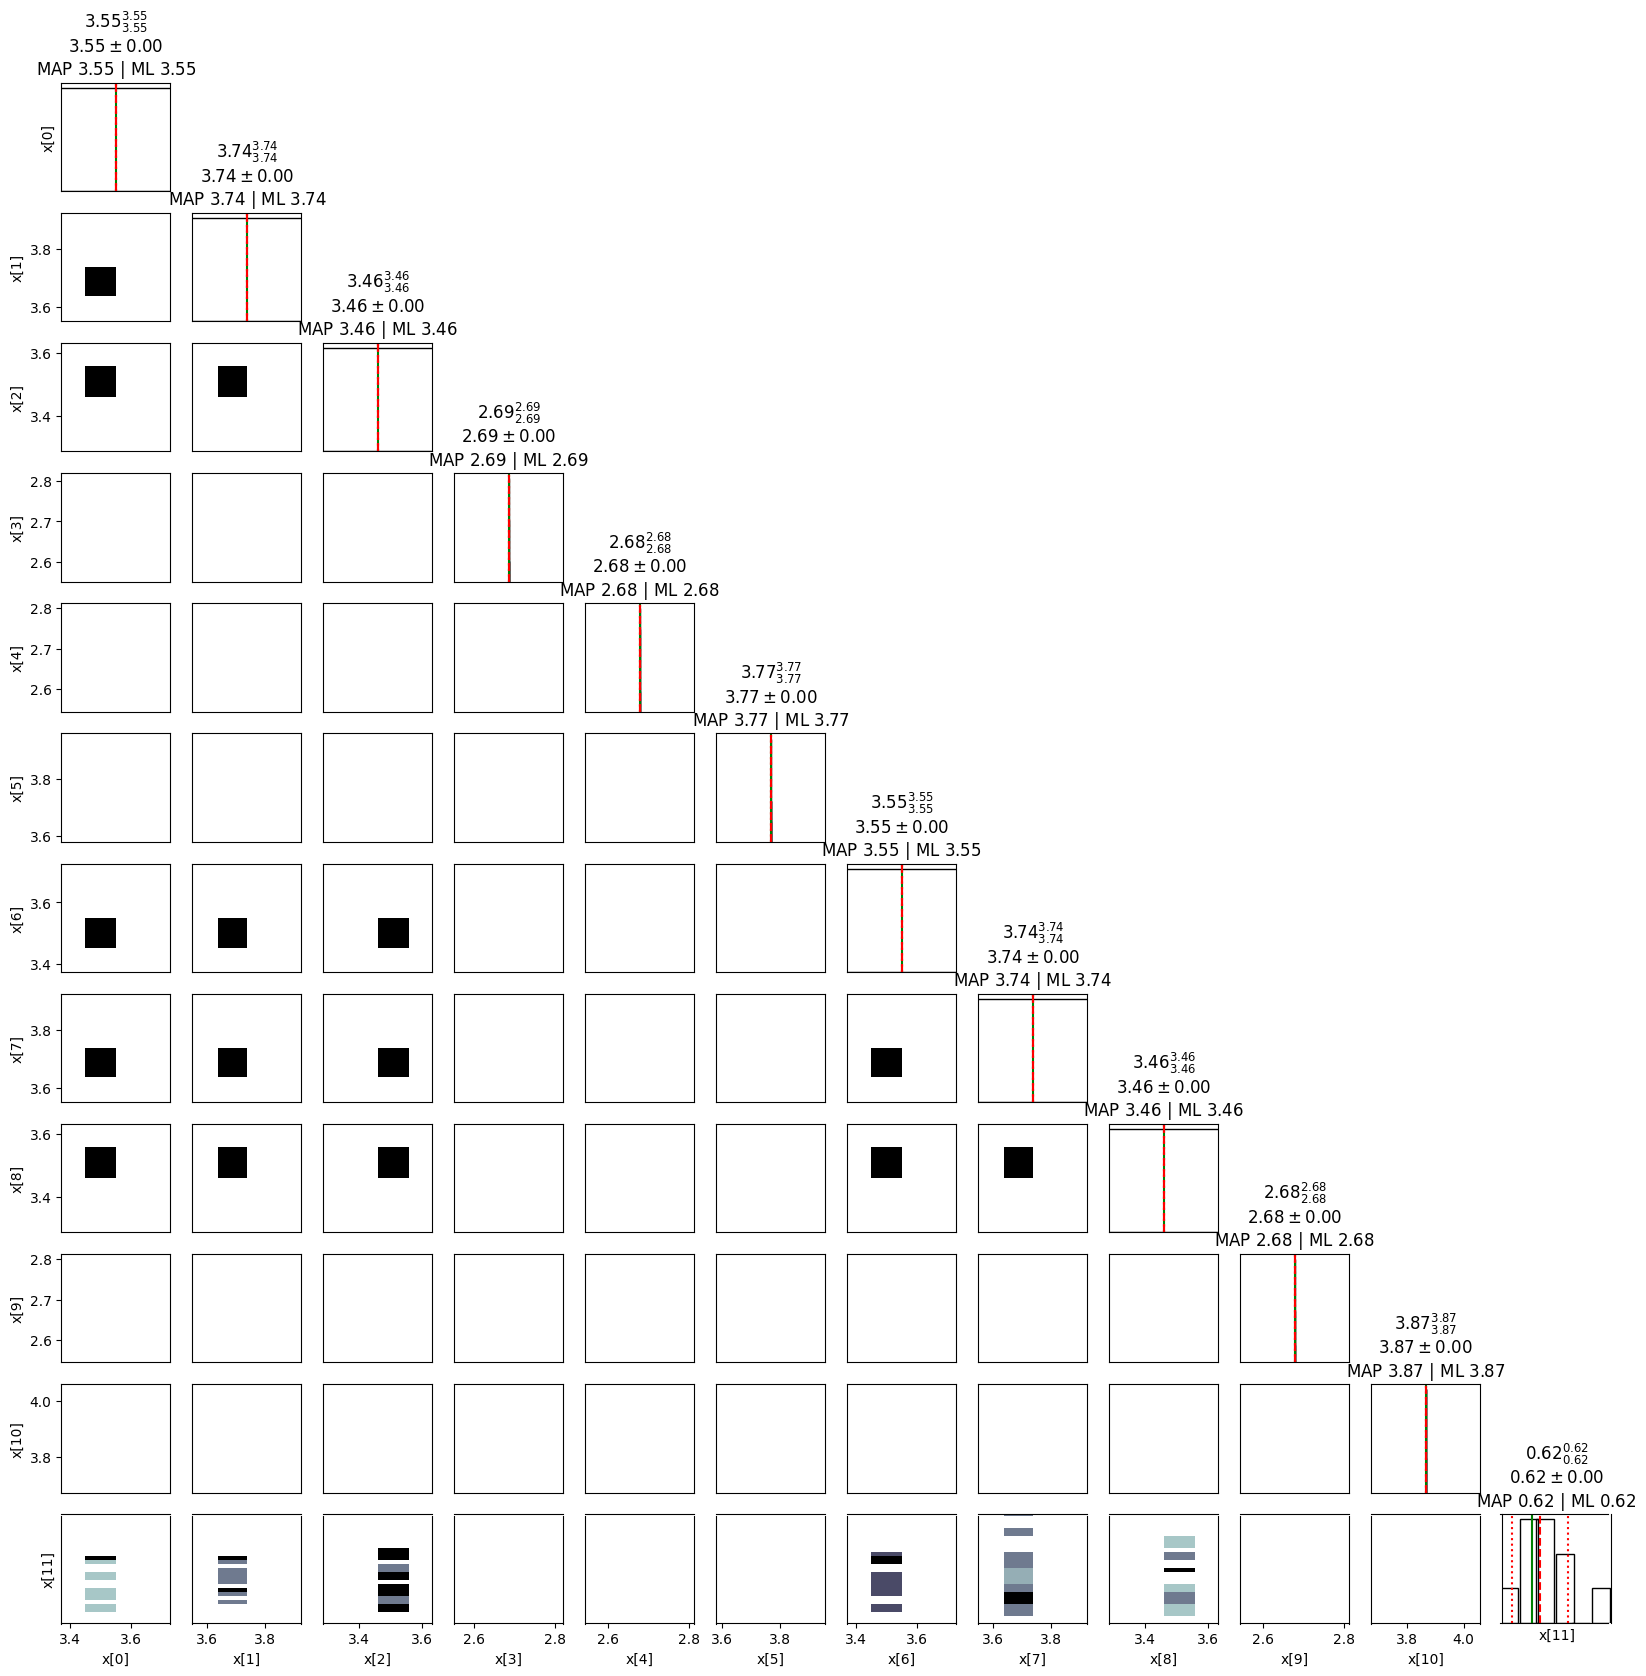

In [6]:
from jaxns import plot_diagnostics, plot_cornerplot

# We plot useful diagnostics and a distribution cornerplot
plot_diagnostics(results)
plot_cornerplot(results)


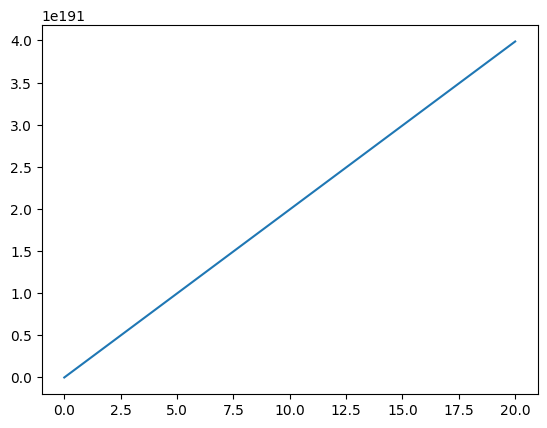

In [7]:
from jax import jit


@jit
def compute_partition(beta):
    # return jnp.sum(results.log_dp_mean * jnp.exp(beta * results.log_L_samples))
    dp_mean = LogSpace(results.log_dp_mean)
    exp_beta_negE = LogSpace(beta * results.log_L_samples)
    return (dp_mean * exp_beta_negE).sum().log_abs_val


x = []
y = []
for beta in jnp.linspace(0, 20, 2000):
    Z_beta = compute_partition(beta)
    x.append(beta)
    y.append(Z_beta)

import pylab as plt

plt.plot(x, y)
plt.show()